# Fundamentals of Deep Learning
## 目录
- Chapter 6. Embedding and Representation Learning

## Learning Lower-Dimensional Representations
![6-1](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0601.png)

Figure 6-1. Using embeddings to automate feature selection in the face of scarce labeled data

## Principal Component Analysis
More specifically, if we have d-dimensional data, we’d like to find a new set of m < d dimensions that conserves as much valuable information from the original dataset. 

First we find a unit vector along which the dataset has maximum variance.  Because this direction contains the most information, we select this direction as our first axis. Then from the set of vectors orthogonal to this first choice, we pick a new unit vector along which the dataset has maximum variance. This is our second axis. We continue this process until we have found a total of d new vectors that represent new axes. We project our data onto this new set of axes.  We then decide a good value for m and toss out all but the first m axes (the principal components, which store the most information). The result is shown in Figure 6-2.

![6-2](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0602.png)

Figure 6-2. An illustration of PCA for dimensionality reduction to capture the dimension with the most information (as proxied by variance)

While PCA has been used for decades for dimensionality reduction, it spectacularly fails to capture important relationships that are piecewise linear or nonlinear.

![6-3](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0603.png)

Figure 6-3. A situation in which PCA fails to optimally transform the data for dimensionality reduction

## Motivating the Autoencoder Architecture
![6-4](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0604.png)

Figure 6-4. The autoencoder architecture attempts to construct a high-dimensional input into a low-dimensional embedding and then uses that low-dimensional embedding to reconstruct the input

## Implementing an Autoencoder in TensorFlow
“Reducing the dimensionality of data with neural networks”(Hinton and Salakhutdinov in 2006):Their hypothesis was that **the nonlinear complexities afforded by a neural model would allow them to capture structure that linear methods, such as PCA, would miss.**

![6-5](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0605.png)

Figure 6-5. The experimental setup for dimensionality reduction of the MNIST dataset employed by Hinton and Salakhutdinov, 2006

In [2]:
%matplotlib inline

def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)

    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = tf.cond(phase_train,
        mean_var_with_update,
        lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var,
        beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(2.0/weight_shape[0])**0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.relu(layer_batch_norm(logits, weight_shape[1], phase_train))

def encoder(x, phase_train):
    with tf.variable_scope("encoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [784, n_encoder_hidden_1], [n_encoder_hidden_1], phase_train)
         
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_encoder_hidden_1, n_encoder_hidden_2], [n_encoder_hidden_2], phase_train)
         
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_encoder_hidden_2, n_encoder_hidden_3], [n_encoder_hidden_3], phase_train)

        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_encoder_hidden_3, n_code], [n_code], phase_train)

    return code

def decoder(code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_decoder_hidden_1], [n_decoder_hidden_1], phase_train)
         
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_decoder_hidden_1, n_decoder_hidden_2], [n_decoder_hidden_2], phase_train)
         
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_decoder_hidden_2, n_decoder_hidden_3], [n_decoder_hidden_3], phase_train)

        with tf.variable_scope("output"):
            output = layer(hidden_3, [n_decoder_hidden_3, 784], [784], phase_train)

    return output

def loss(output, x):
    with tf.variable_scope("training"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        train_summary_op = tf.summary.scalar("train_cost", train_loss)
        return train_loss, train_summary_op

def training(cost, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, 
        use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

def image_summary(label, tensor):
    tensor_reshaped = tf.reshape(tensor, [-1, 28, 28, 1])
    return tf.summary.image(label, tensor_reshaped)

def evaluate(output, x):
    with tf.variable_scope("validation"):
        in_im_op = image_summary("input_image", x)
        out_im_op = image_summary("output_image", output)
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_loss = tf.reduce_mean(l2)
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        return val_loss, in_im_op, out_im_op, val_summary_op

- The output of the decoder network is a 784-dimensional vector  that can be reconstructed into a 28 × 28 image.
- In order to accelerate training, we’ll reuse the batch normalization strategy we employed in Chapter 5.
- Loss
    - Given an input vector upper I and a reconstruction upper O
    - $\lVert I-O \rVert=\sqrt{\sum_i(I_i-O_i)^2}$, also known as the L2 norm of the difference between the two vectors
- Evaluate
    - Use a validation dataset and compute the same L2 norm measurement for model evaluation.
    - Collect image summaries so that we can compare both the input images and the reconstructions.

In [18]:
import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

import tensorflow as tf

# Architecture
n_encoder_hidden_1 = 1000
n_encoder_hidden_2 = 500
n_encoder_hidden_3 = 250
n_code = 30
n_decoder_hidden_1 = 250
n_decoder_hidden_2 = 500
n_decoder_hidden_3 = 1000

# Parameters
learning_rate = 0.01
training_epochs = 500
batch_size = 100
display_step = 100

with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        x = tf.placeholder("float", [None, 784]) # mnist data image of shape 28*28=784
        phase_train = tf.placeholder(tf.bool)

        code = encoder(x, phase_train)
        output = decoder(code, phase_train)
        cost, train_summary_op = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = training(cost, global_step)
        eval_op, in_im_op, out_im_op, val_summary_op = evaluate(output, x)
        summary_op = tf.summary.merge_all()

        saver = tf.train.Saver()
        sess = tf.Session()
        train_writer = tf.summary.FileWriter("mnist_autoencoder_logs/", graph=sess.graph)
        val_writer = tf.summary.FileWriter("mnist_autoencoder_logs/",graph=sess.graph)

        init_op = tf.global_variables_initializer()
        sess.run(init_op)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(mnist.train.num_examples/batch_size)
            # Loop over all batches
            for i in range(total_batch):
                minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
                # Fit training using batch data
                _, new_cost, train_summary = sess.run([train_op, cost, train_summary_op], feed_dict={x: minibatch_x, phase_train: True})
                train_writer.add_summary(train_summary, sess.run(global_step))
                # Compute average loss
                avg_cost += new_cost/total_batch
            # Display logs per epoch step
            if epoch % display_step == 0:
                print "Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost)

                validation_loss, in_im, out_im, val_summary = sess.run([eval_op, in_im_op, out_im_op, val_summary_op], feed_dict={x: mnist.validation.images, phase_train: False})
                val_writer.add_summary(in_im, sess.run(global_step))
                val_writer.add_summary(out_im, sess.run(global_step))
                val_writer.add_summary(val_summary, sess.run(global_step))
                print "Validation Loss:", validation_loss
                saver.save(sess, "mnist_autoencoder_logs/model-checkpoint", global_step=global_step)

        print "Optimization Finished!"
        test_loss = sess.run(eval_op, feed_dict={x: mnist.test.images, phase_train: False})
        print "Test Loss:", loss

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost = 5.726947857
Validation Loss: 4.45524
Epoch: 0101 cost = 1.875294229
Validation Loss: 1.81979
Epoch: 0201 cost = 1.757120199
Validation Loss: 1.76411
Epoch: 0301 cost = 1.665520479
Validation Loss: 1.77019
Epoch: 0401 cost = 1.611918144
Validation Loss: 1.75243
Optimization Finished!
Test Loss: <function loss at 0x10462baa0>


The reconstructions for three randomly chosen samples from the test set are shown in Figure 6-9.

![6-9](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0609.png)

Figure 6-9. A side-by-side comparison of the original inputs (from the validation set) and reconstructions after 5, 100, and 200 epochs of training

In [3]:
from sklearn import decomposition
import input_data

mnist = input_data.read_data_sets("data/", one_hot=False)
pca = decomposition.PCA(n_components=2)
pca.fit(mnist.train.images)
pca_codes = pca.transform(mnist.test.images)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


- `one_hot=False`:labels to be provided as integers instead of one-hot vectors.
- `n_components=2`:to generate two-dimensional codes.

We can also reconstruct the original images from the two-dimensional codes and visualize the reconstructions:

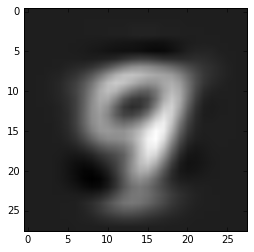

In [4]:
from matplotlib import pyplot as plt

pca_recon = pca.inverse_transform(pca_codes[:1])
plt.imshow(pca_recon[0].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

![6-10](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0610.png)

Figure 6-10. Comparing the reconstructions by both PCA and autoencoder side by side

In the resulting visualization in Figure 6-11, it is extremely difficult to make out separable clusters in the two-dimensional PCA codes; the autoencoder has clearly done a spectacular job at clustering codes of different digit classes. This means that **a simple machine learning model is going to be able to much more effectively classify data points consisting of autoencoder embeddings as compared to PCA embeddings.**

![6-11](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0611.png)

Figure 6-11. We visualize two-dimensional embeddings produced by PCA (left) and by an autoencoder (right). Notice that the autoencoder does a much better job of clustering codes of different digit classes.

## Denoising to Force Robust Representations
![6-12](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0612.png)

Figure 6-12. In the top row, we have original images from the MNIST dataset. In the bottom row, we’ve randomly blacked out half of the pixels. Despite the corruption, the digits in the bottom row are still identifiable by human perception. 

This is a property we might hope to enforce in our embedding algorithm, and it was first explored by Vincent et al. in 2008, when they introduced the `denoising autoencoder`.

Let’s say we had a two-dimensional dataset with various labels. Let’s take all of the data points in a particular category (i.e., with some fixed label), and call this subset of data points S. While any arbitrary sampling of points could end up taking any form while visualized, we presume that for real-life categories, there is some underlying structure that unifies all of the points in S. This underlying, unifying geometric structure is known as a `manifold`. The manifold is the shape that we want to capture when we reduce the dimensionality of our data; and as Alain and Bengio described in 2014, our autoencoder is implicitly learning this manifold as it learns how to reconstruct data after pushing it through a bottleneck (the code layer). The autoencoder must figure out whether a point belongs to one manifold or another when trying to generate a reconstruction of an instance with potentially different labels.

![6-14](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0614.png)

Figure 6-14. We apply a corruption operation to the dataset and train a denoising autoencoder to reconstruct the original, uncorrupted images

## Sparsity in Autoencoders
`Interpretability` is a property of a machine learning model that measures how easy it is to inspect and explain its process and/or output. Deep models are generally very difficult to interpret because of the nonlinearities and massive numbers of parameters that make up a model.

In general, an autoencoder’s representations are dense, and this has implications with respect to how the representation changes as we make coherent modifications to the input. Consider the situation in Figure 6-15.

![6-15](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0615.png)

Figure 6-15. The activations of a dense representation combine and overlay information from multiple features in ways that are difficult to interpret

The ideal outcome for us is if we can build a representation where there is a 1-to-1 correspondence, or close to a 1-to-1 correspondence, between high-level features and individual components in the code. When we are able to achieve this, we get very close to the system described in Figure 6-16. Part A of the figure shows how the representation changes as we add and remove components, and part B color-codes the correspondence between strokes and the components in the code. In this setup, it’s quite clear how and why the representation changes—the representation is very clearly the sum of the individual strokes in the image.

![6-16](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0616.png)

Figure 6-16. With the right combination of space and sparsity, a representation is more interpretable. In A, we show how activations in the representation change with the addition and removal of strokes. In B, we color-code the activations that correspond to each stroke to highlight our ability to interpret how a stroke affects the representation. 

We’ve explored how we can use autoencoders to find strong representations of data points by summarizing their content. This mechanism of dimensionality reduction works well when the independent data points are rich and contain all of the relevant information pertaining to their structure in their original representation.

## When Context Is More Informative than the Input Vector
![6-17](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0617.png)

Figure 6-17. An example of generating one-hot vector representations for words using a simple document

Overall, as illustrated in Figure 6-18,  by analyzing the context (i.e., a fixed window of words surrounding a target word), we can quickly surmise the meaning of the word.

![6-18](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0618.png)

Figure 6-18. We can identify words with similar meanings based on their contexts. For example, the words “jumps” and “leaps” should have similar vector representations because they are virtually interchangeable. Moreover, we can draw conclusions about what the words “jumps” and “leaps” mean just by looking at the words around them. 

It turns out we can use the same principles we used when building the autoencoder to build a network that builds strong, distributed representations. Two strategies are shown in Figure 6-19.

![6-19](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0619.png)

Figure 6-19. General architectures for designing encoders and decoders that generate embeddings by mapping words to their respective contexts (A) or vice versa (B)

## The Word2Vec Framework
The `CBOW`(Continuous Bag of Words) model used the encoder to create an embedding from the full context (treated as one input) and predict the target word.

The `Skip-Gram` model does the inverse of CBOW, taking the target word as an input, and then attempting to predict one of the words in the context.

Consider the sentence “the boy went to the bank.” If we broke this sentence down into a sequence of (context, target) pairs, we would obtain [([the, went], boy), ([boy, to], went), ([went, the], to), ([to, bank], the)]. Taking this a step further, we have to split each (context, target) pair into (input, output) pairs where the input is the target and the output is one of the words from the context. From the first pair ([the, went], boy), we would generate the two pairs (boy, the) and (boy, went). We continue to apply this operation to every (context, target) pair to build our dataset. Finally, we replace each word with its unique index $i \in \{0,1,\cdots,|V|-1\}$ corresponding to its index in the vocabulary.

The structure of the encoder is surprisingly simple. It is essentially a lookup table with |V| rows, where the $i^{th}$ row is the embedding corresponding to the $i^{th}$ vocabulary word. All the encoder has to do is take the index of the input word and output the appropriate row in the lookup table.

We can implement this simply in TensorFlow with the following TensorFlow function:

```py
tf.nn.embedding_lookup(params, ids, partition_strategy='mod', 
                       name=None, validate_indices=True)
```

- `params` is the embedding matrix
- `ids` is a tensor of indices we want to look up

The naive way to construct the decoder would be to attempt to reconstruct the one-hot encoding vector for the output, which we could implement with a run-of-the-mill feed-forward layer coupled with a softmax. The only concern is that it’s inefficient because we have to produce a probability distribution over the whole vocabulary space.

To reduce the number of parameters, Mikolov et al. used a strategy for implementing the decoder known as `noise-contrastive estimation` (NCE). The strategy is illustrated in Figure 6-20.

![6-20](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/assets/fodl_0620.png)

Figure 6-20. An illustration of how noise-contrastive estimation works. A binary logistic regression compares the embedding of the target with the embedding of a context word and randomly sampled noncontext words. We construct a loss function describing how effectively the embeddings enable identification of words in the context of the target versus words outside the context of the target. 

The NCE strategy uses the lookup table to find the embedding for the output, as well as embeddings for random selections from the vocabulary that are not in the context of the input. We then employ a binary logistic regression model that, one at a time, takes the input embedding and the embedding of the output or random selection, and then outputs a value between 0 to 1 corresponding to the probability that the comparison embedding represents a vocabulary word present in the input’s context. We then take the sum of the probabilities corresponding to the noncontext comparisons and subtract the probability corresponding to the context comparison. This value is the objective function that we want to minimize (in the optimal scenario where the model has perfect performance, the value will be -1).  Implementing NCE in TensorFlow utilizes the following code snippet:

```py
tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, 
               num_classes, num_true=1, sampled_values=None, 
               remove_accidental_hits=False, 
               partition_strategy='mod', 
               name='nce_loss')
```

- `weights` should have the same dimensions as the embedding matrix
- `biases` should be a tensor with size equal to the vocabulary
- `inputs` are the results from the embedding lookup
- `num_sampled` is the number of negative samples we use to compute the NCE
- `num_classes` is the vocabulary size

In [17]:
def embedding_layer(x, embedding_shape):
    with tf.variable_scope("embedding"):
        embedding_init = tf.random_uniform(embedding_shape, -1.0, 1.0)
        embedding_matrix = tf.get_variable("E", initializer=embedding_init)
        return tf.nn.embedding_lookup(embedding_matrix, x), embedding_matrix

def noise_contrastive_loss(embedding_lookup, weight_shape, bias_shape, y):
    with tf.variable_scope("nce"):
        nce_weight_init = tf.truncated_normal(weight_shape, stddev=1.0/(weight_shape[1])**0.5)
        nce_bias_init = tf.zeros(bias_shape)
        nce_W = tf.get_variable("W", initializer=nce_weight_init)
        nce_b = tf.get_variable("b", initializer=nce_bias_init)

        total_loss = tf.nn.nce_loss(nce_W, nce_b, y, embedding_lookup, neg_size, data.vocabulary_size)
        return tf.reduce_mean(total_loss)

def training(cost, global_step):
    with tf.variable_scope("training"):
        summary_op = tf.summary.scalar("cost", cost)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(cost, global_step=global_step)
        return train_op, summary_op

def validation(embedding_matrix, x_val):
    norm = tf.reduce_sum(embedding_matrix**2, 1, keep_dims=True)**0.5
    normalized = embedding_matrix/norm
    val_embeddings = tf.nn.embedding_lookup(normalized, x_val)
    cosine_similarity = tf.matmul(val_embeddings, normalized, transpose_b=True)
    return normalized, cosine_similarity

- `embedding_layer`:initialize the lookup table  with a matrix of values
- `noise_contrastive_loss`:compute the NCE cost for each training example, and then compile all of the results in the minibatch into a single measurement
- `training`:employ stochastic gradient descent with a learning rate of 0.1

In [19]:
import input_word_data as data
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# TRAINING PARAMETERS
batch_size = 32                                             # Number of training examples per batch
embedding_size = 128                                        # Dimension of embedding vectors
skip_window = 5                                             # Window size for context to the left and right of target
num_skips = 4                                               # How many times to reuse target to generate a label for context.
batches_per_epoch = data.data_size*num_skips/batch_size     # Number of batches per epoch of training
training_epochs = 5                                         # Number of epochs to utilize for training
neg_size = 64                                               # Number of negative samples to use for NCE
display_step = 20000                                         # Frequency with which to print statistics
val_step = 10000                                            # Frequency with which to perform validation
learning_rate = 0.1                                         # Learning rate for SGD

print "Epochs: %d, Batches per epoch: %d, Examples per batch: %d" % (training_epochs, batches_per_epoch, batch_size)

# NEAREST NEIGHBORS VALIDATION PARAMETERS
val_size = 20
val_dist_span = 500
val_examples = np.random.choice(val_dist_span, val_size, replace=False)
top_match = 8
plot_num = 500

# Main function
with tf.Graph().as_default():
    with tf.variable_scope("skipgram_model"):
        x = tf.placeholder(tf.int32, shape=[batch_size])
        y = tf.placeholder(tf.int32, [batch_size, 1])
        val = tf.constant(val_examples, dtype=tf.int32)
        global_step = tf.Variable(0, name='global_step', trainable=False)

        e_lookup, e_matrix = embedding_layer(x, [data.vocabulary_size, embedding_size])

        cost = noise_contrastive_loss(e_lookup, [data.vocabulary_size, embedding_size], [data.vocabulary_size], y)

        train_op, summary_op = training(cost, global_step)

        val_op = validation(e_matrix, val)

        sess = tf.Session()

        train_writer = tf.summary.FileWriter("skipgram_logs/", graph=sess.graph)

        init_op = tf.global_variables_initializer()

        sess.run(init_op)

        step = 0
        avg_cost = 0

        for epoch in xrange(training_epochs):
            for minibatch in xrange(batches_per_epoch):
                step +=1
                minibatch_x, minibatch_y = data.generate_batch(batch_size, num_skips, skip_window)
                feed_dict = {x : minibatch_x, y : minibatch_y}

                _, new_cost, train_summary = sess.run([train_op, cost, summary_op], feed_dict=feed_dict)
                train_writer.add_summary(train_summary, sess.run(global_step))
                # Compute average loss
                avg_cost += new_cost/display_step

                if step % display_step == 0:
                    print "Elapsed:", str(step), "batches. Cost =", "{:.9f}".format(avg_cost)
                    avg_cost = 0

                if step % val_step == 0:
                    _, similarity = sess.run(val_op)
                    for i in xrange(val_size):
                        val_word = data.reverse_dictionary[val_examples[i]]
                        neighbors = (-similarity[i, :]).argsort()[1:top_match+1]
                        print_str = "Nearest neighbor of %s:" % val_word
                        for k in xrange(top_match):
                            print_str += " %s," % data.reverse_dictionary[neighbors[k]]
                        print print_str[:-1]

        final_embeddings, _ = sess.run(val_op)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_embeddings = np.asfarray(final_embeddings[:plot_num,:], dtype='float')
low_dim_embs = tsne.fit_transform(plot_embeddings)
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
data.plot_with_labels(low_dim_embs, labels)

Epochs: 5, Batches per epoch: 2125650, Examples per batch: 32
Nearest neighbor of major: cinema, french, film, using, well, united, being, italian
Nearest neighbor of december: first, some, federal, now, shot, surnames, but, system
Nearest neighbor of c: be, funk, notable, who, zero, star, court, from
Nearest neighbor of modern: seven, nine, s, eight, films, he, been, was
Nearest neighbor of since: which, cinema, nine, many, they, at, he, were
Nearest neighbor of empire: product, setting, planet, i, peak, brain, skin, subject
Nearest neighbor of thus: copyright, on, cinema, films, film, four, problems, french
Nearest neighbor of james: g, nine, or, now, nature, there, french, funk
Nearest neighbor of band: production, until, television, links, dune, filmmakers, word, schools
Nearest neighbor of china: e, other, usually, fm, all, important, most, main
Nearest neighbor of character: see, n, ford, language, wave, family, money, other
Nearest neighbor of area: some, as, time, law, six, oft

NameError: name 'plot_only' is not defined